# Model Selection for Multilayer Perceptron Using Keras and MADlib

E2E classification example using MADlib calling a Keras MLP for different hyperparameters and model architectures.

Deep learning works best on very large datasets, but that is not convenient for a quick introduction to the syntax.  So in this workbook we use the well known iris data set from https://archive.ics.uci.edu/ml/datasets/iris to help get you started.  It is similar to the example in user docs http://madlib.apache.org/docs/latest/index.html

For more realistic examples please refer to the deep learning notebooks at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts

## Table of contents

<a href="#class">Classification</a>

* <a href="#create_input_data">1. Create input data</a>

* <a href="#pp">2. Call preprocessor for deep learning</a>

* <a href="#load">3. Define and load model architecture</a>

* <a href="#def_mst">4. Define and load model selection tuples</a>

* <a href="#train">5. Train</a>

* <a href="#eval">6. Evaluate</a>

* <a href="#pred">7. Predict</a>

<a href="#class2">Classification with Other Parameters</a>

* <a href="#val_dataset">1. Validation dataset</a>

* <a href="#pred_prob">2. Predict probabilities</a>

* <a href="#warm_start">3. Warm start</a>

In [1]:
%load_ext sql

In [2]:
# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


[(u'MADlib version: 1.18.0-dev, git revision: rel/v1.17.0-89-g14a91ce, cmake configuration time: Fri Mar  5 23:08:38 UTC 2021, build type: release, build system: Linux-3.10.0-1160.11.1.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5',)]

<a id="class"></a>
# Classification

<a id="create_input_data"></a>
# 1.  Create input data

Load iris data set.

In [4]:
%%sql 
DROP TABLE IF EXISTS iris_data;

CREATE TABLE iris_data(
    id serial,
    attributes numeric[],
    class_text varchar
);

INSERT INTO iris_data(id, attributes, class_text) VALUES
(1,ARRAY[5.1,3.5,1.4,0.2],'Iris-setosa'),
(2,ARRAY[4.9,3.0,1.4,0.2],'Iris-setosa'),
(3,ARRAY[4.7,3.2,1.3,0.2],'Iris-setosa'),
(4,ARRAY[4.6,3.1,1.5,0.2],'Iris-setosa'),
(5,ARRAY[5.0,3.6,1.4,0.2],'Iris-setosa'),
(6,ARRAY[5.4,3.9,1.7,0.4],'Iris-setosa'),
(7,ARRAY[4.6,3.4,1.4,0.3],'Iris-setosa'),
(8,ARRAY[5.0,3.4,1.5,0.2],'Iris-setosa'),
(9,ARRAY[4.4,2.9,1.4,0.2],'Iris-setosa'),
(10,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(11,ARRAY[5.4,3.7,1.5,0.2],'Iris-setosa'),
(12,ARRAY[4.8,3.4,1.6,0.2],'Iris-setosa'),
(13,ARRAY[4.8,3.0,1.4,0.1],'Iris-setosa'),
(14,ARRAY[4.3,3.0,1.1,0.1],'Iris-setosa'),
(15,ARRAY[5.8,4.0,1.2,0.2],'Iris-setosa'),
(16,ARRAY[5.7,4.4,1.5,0.4],'Iris-setosa'),
(17,ARRAY[5.4,3.9,1.3,0.4],'Iris-setosa'),
(18,ARRAY[5.1,3.5,1.4,0.3],'Iris-setosa'),
(19,ARRAY[5.7,3.8,1.7,0.3],'Iris-setosa'),
(20,ARRAY[5.1,3.8,1.5,0.3],'Iris-setosa'),
(21,ARRAY[5.4,3.4,1.7,0.2],'Iris-setosa'),
(22,ARRAY[5.1,3.7,1.5,0.4],'Iris-setosa'),
(23,ARRAY[4.6,3.6,1.0,0.2],'Iris-setosa'),
(24,ARRAY[5.1,3.3,1.7,0.5],'Iris-setosa'),
(25,ARRAY[4.8,3.4,1.9,0.2],'Iris-setosa'),
(26,ARRAY[5.0,3.0,1.6,0.2],'Iris-setosa'),
(27,ARRAY[5.0,3.4,1.6,0.4],'Iris-setosa'),
(28,ARRAY[5.2,3.5,1.5,0.2],'Iris-setosa'),
(29,ARRAY[5.2,3.4,1.4,0.2],'Iris-setosa'),
(30,ARRAY[4.7,3.2,1.6,0.2],'Iris-setosa'),
(31,ARRAY[4.8,3.1,1.6,0.2],'Iris-setosa'),
(32,ARRAY[5.4,3.4,1.5,0.4],'Iris-setosa'),
(33,ARRAY[5.2,4.1,1.5,0.1],'Iris-setosa'),
(34,ARRAY[5.5,4.2,1.4,0.2],'Iris-setosa'),
(35,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(36,ARRAY[5.0,3.2,1.2,0.2],'Iris-setosa'),
(37,ARRAY[5.5,3.5,1.3,0.2],'Iris-setosa'),
(38,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(39,ARRAY[4.4,3.0,1.3,0.2],'Iris-setosa'),
(40,ARRAY[5.1,3.4,1.5,0.2],'Iris-setosa'),
(41,ARRAY[5.0,3.5,1.3,0.3],'Iris-setosa'),
(42,ARRAY[4.5,2.3,1.3,0.3],'Iris-setosa'),
(43,ARRAY[4.4,3.2,1.3,0.2],'Iris-setosa'),
(44,ARRAY[5.0,3.5,1.6,0.6],'Iris-setosa'),
(45,ARRAY[5.1,3.8,1.9,0.4],'Iris-setosa'),
(46,ARRAY[4.8,3.0,1.4,0.3],'Iris-setosa'),
(47,ARRAY[5.1,3.8,1.6,0.2],'Iris-setosa'),
(48,ARRAY[4.6,3.2,1.4,0.2],'Iris-setosa'),
(49,ARRAY[5.3,3.7,1.5,0.2],'Iris-setosa'),
(50,ARRAY[5.0,3.3,1.4,0.2],'Iris-setosa'),
(51,ARRAY[7.0,3.2,4.7,1.4],'Iris-versicolor'),
(52,ARRAY[6.4,3.2,4.5,1.5],'Iris-versicolor'),
(53,ARRAY[6.9,3.1,4.9,1.5],'Iris-versicolor'),
(54,ARRAY[5.5,2.3,4.0,1.3],'Iris-versicolor'),
(55,ARRAY[6.5,2.8,4.6,1.5],'Iris-versicolor'),
(56,ARRAY[5.7,2.8,4.5,1.3],'Iris-versicolor'),
(57,ARRAY[6.3,3.3,4.7,1.6],'Iris-versicolor'),
(58,ARRAY[4.9,2.4,3.3,1.0],'Iris-versicolor'),
(59,ARRAY[6.6,2.9,4.6,1.3],'Iris-versicolor'),
(60,ARRAY[5.2,2.7,3.9,1.4],'Iris-versicolor'),
(61,ARRAY[5.0,2.0,3.5,1.0],'Iris-versicolor'),
(62,ARRAY[5.9,3.0,4.2,1.5],'Iris-versicolor'),
(63,ARRAY[6.0,2.2,4.0,1.0],'Iris-versicolor'),
(64,ARRAY[6.1,2.9,4.7,1.4],'Iris-versicolor'),
(65,ARRAY[5.6,2.9,3.6,1.3],'Iris-versicolor'),
(66,ARRAY[6.7,3.1,4.4,1.4],'Iris-versicolor'),
(67,ARRAY[5.6,3.0,4.5,1.5],'Iris-versicolor'),
(68,ARRAY[5.8,2.7,4.1,1.0],'Iris-versicolor'),
(69,ARRAY[6.2,2.2,4.5,1.5],'Iris-versicolor'),
(70,ARRAY[5.6,2.5,3.9,1.1],'Iris-versicolor'),
(71,ARRAY[5.9,3.2,4.8,1.8],'Iris-versicolor'),
(72,ARRAY[6.1,2.8,4.0,1.3],'Iris-versicolor'),
(73,ARRAY[6.3,2.5,4.9,1.5],'Iris-versicolor'),
(74,ARRAY[6.1,2.8,4.7,1.2],'Iris-versicolor'),
(75,ARRAY[6.4,2.9,4.3,1.3],'Iris-versicolor'),
(76,ARRAY[6.6,3.0,4.4,1.4],'Iris-versicolor'),
(77,ARRAY[6.8,2.8,4.8,1.4],'Iris-versicolor'),
(78,ARRAY[6.7,3.0,5.0,1.7],'Iris-versicolor'),
(79,ARRAY[6.0,2.9,4.5,1.5],'Iris-versicolor'),
(80,ARRAY[5.7,2.6,3.5,1.0],'Iris-versicolor'),
(81,ARRAY[5.5,2.4,3.8,1.1],'Iris-versicolor'),
(82,ARRAY[5.5,2.4,3.7,1.0],'Iris-versicolor'),
(83,ARRAY[5.8,2.7,3.9,1.2],'Iris-versicolor'),
(84,ARRAY[6.0,2.7,5.1,1.6],'Iris-versicolor'),
(85,ARRAY[5.4,3.0,4.5,1.5],'Iris-versicolor'),
(86,ARRAY[6.0,3.4,4.5,1.6],'Iris-versicolor'),
(87,ARRAY[6.7,3.1,4.7,1.5],'Iris-versicolor'),
(88,ARRAY[6.3,2.3,4.4,1.3],'Iris-versicolor'),
(89,ARRAY[5.6,3.0,4.1,1.3],'Iris-versicolor'),
(90,ARRAY[5.5,2.5,4.0,1.3],'Iris-versicolor'),
(91,ARRAY[5.5,2.6,4.4,1.2],'Iris-versicolor'),
(92,ARRAY[6.1,3.0,4.6,1.4],'Iris-versicolor'),
(93,ARRAY[5.8,2.6,4.0,1.2],'Iris-versicolor'),
(94,ARRAY[5.0,2.3,3.3,1.0],'Iris-versicolor'),
(95,ARRAY[5.6,2.7,4.2,1.3],'Iris-versicolor'),
(96,ARRAY[5.7,3.0,4.2,1.2],'Iris-versicolor'),
(97,ARRAY[5.7,2.9,4.2,1.3],'Iris-versicolor'),
(98,ARRAY[6.2,2.9,4.3,1.3],'Iris-versicolor'),
(99,ARRAY[5.1,2.5,3.0,1.1],'Iris-versicolor'),
(100,ARRAY[5.7,2.8,4.1,1.3],'Iris-versicolor'),
(101,ARRAY[6.3,3.3,6.0,2.5],'Iris-virginica'),
(102,ARRAY[5.8,2.7,5.1,1.9],'Iris-virginica'),
(103,ARRAY[7.1,3.0,5.9,2.1],'Iris-virginica'),
(104,ARRAY[6.3,2.9,5.6,1.8],'Iris-virginica'),
(105,ARRAY[6.5,3.0,5.8,2.2],'Iris-virginica'),
(106,ARRAY[7.6,3.0,6.6,2.1],'Iris-virginica'),
(107,ARRAY[4.9,2.5,4.5,1.7],'Iris-virginica'),
(108,ARRAY[7.3,2.9,6.3,1.8],'Iris-virginica'),
(109,ARRAY[6.7,2.5,5.8,1.8],'Iris-virginica'),
(110,ARRAY[7.2,3.6,6.1,2.5],'Iris-virginica'),
(111,ARRAY[6.5,3.2,5.1,2.0],'Iris-virginica'),
(112,ARRAY[6.4,2.7,5.3,1.9],'Iris-virginica'),
(113,ARRAY[6.8,3.0,5.5,2.1],'Iris-virginica'),
(114,ARRAY[5.7,2.5,5.0,2.0],'Iris-virginica'),
(115,ARRAY[5.8,2.8,5.1,2.4],'Iris-virginica'),
(116,ARRAY[6.4,3.2,5.3,2.3],'Iris-virginica'),
(117,ARRAY[6.5,3.0,5.5,1.8],'Iris-virginica'),
(118,ARRAY[7.7,3.8,6.7,2.2],'Iris-virginica'),
(119,ARRAY[7.7,2.6,6.9,2.3],'Iris-virginica'),
(120,ARRAY[6.0,2.2,5.0,1.5],'Iris-virginica'),
(121,ARRAY[6.9,3.2,5.7,2.3],'Iris-virginica'),
(122,ARRAY[5.6,2.8,4.9,2.0],'Iris-virginica'),
(123,ARRAY[7.7,2.8,6.7,2.0],'Iris-virginica'),
(124,ARRAY[6.3,2.7,4.9,1.8],'Iris-virginica'),
(125,ARRAY[6.7,3.3,5.7,2.1],'Iris-virginica'),
(126,ARRAY[7.2,3.2,6.0,1.8],'Iris-virginica'),
(127,ARRAY[6.2,2.8,4.8,1.8],'Iris-virginica'),
(128,ARRAY[6.1,3.0,4.9,1.8],'Iris-virginica'),
(129,ARRAY[6.4,2.8,5.6,2.1],'Iris-virginica'),
(130,ARRAY[7.2,3.0,5.8,1.6],'Iris-virginica'),
(131,ARRAY[7.4,2.8,6.1,1.9],'Iris-virginica'),
(132,ARRAY[7.9,3.8,6.4,2.0],'Iris-virginica'),
(133,ARRAY[6.4,2.8,5.6,2.2],'Iris-virginica'),
(134,ARRAY[6.3,2.8,5.1,1.5],'Iris-virginica'),
(135,ARRAY[6.1,2.6,5.6,1.4],'Iris-virginica'),
(136,ARRAY[7.7,3.0,6.1,2.3],'Iris-virginica'),
(137,ARRAY[6.3,3.4,5.6,2.4],'Iris-virginica'),
(138,ARRAY[6.4,3.1,5.5,1.8],'Iris-virginica'),
(139,ARRAY[6.0,3.0,4.8,1.8],'Iris-virginica'),
(140,ARRAY[6.9,3.1,5.4,2.1],'Iris-virginica'),
(141,ARRAY[6.7,3.1,5.6,2.4],'Iris-virginica'),
(142,ARRAY[6.9,3.1,5.1,2.3],'Iris-virginica'),
(143,ARRAY[5.8,2.7,5.1,1.9],'Iris-virginica'),
(144,ARRAY[6.8,3.2,5.9,2.3],'Iris-virginica'),
(145,ARRAY[6.7,3.3,5.7,2.5],'Iris-virginica'),
(146,ARRAY[6.7,3.0,5.2,2.3],'Iris-virginica'),
(147,ARRAY[6.3,2.5,5.0,1.9],'Iris-virginica'),
(148,ARRAY[6.5,3.0,5.2,2.0],'Iris-virginica'),
(149,ARRAY[6.2,3.4,5.4,2.3],'Iris-virginica'),
(150,ARRAY[5.9,3.0,5.1,1.8],'Iris-virginica');

SELECT * FROM iris_data ORDER BY id;

Done.
Done.
150 rows affected.
150 rows affected.


[(1, [Decimal('5.1'), Decimal('3.5'), Decimal('1.4'), Decimal('0.2')], u'Iris-setosa'),
 (2, [Decimal('4.9'), Decimal('3.0'), Decimal('1.4'), Decimal('0.2')], u'Iris-setosa'),
 (3, [Decimal('4.7'), Decimal('3.2'), Decimal('1.3'), Decimal('0.2')], u'Iris-setosa'),
 (4, [Decimal('4.6'), Decimal('3.1'), Decimal('1.5'), Decimal('0.2')], u'Iris-setosa'),
 (5, [Decimal('5.0'), Decimal('3.6'), Decimal('1.4'), Decimal('0.2')], u'Iris-setosa'),
 (6, [Decimal('5.4'), Decimal('3.9'), Decimal('1.7'), Decimal('0.4')], u'Iris-setosa'),
 (7, [Decimal('4.6'), Decimal('3.4'), Decimal('1.4'), Decimal('0.3')], u'Iris-setosa'),
 (8, [Decimal('5.0'), Decimal('3.4'), Decimal('1.5'), Decimal('0.2')], u'Iris-setosa'),
 (9, [Decimal('4.4'), Decimal('2.9'), Decimal('1.4'), Decimal('0.2')], u'Iris-setosa'),
 (10, [Decimal('4.9'), Decimal('3.1'), Decimal('1.5'), Decimal('0.1')], u'Iris-setosa'),
 (11, [Decimal('5.4'), Decimal('3.7'), Decimal('1.5'), Decimal('0.2')], u'Iris-setosa'),
 (12, [Decimal('4.8'), Decimal('3.4'), Decimal('1.6'), Decimal('0.2')], u'Iris-setosa'),
 (13, [Decimal('4.8'), Decimal('3.0'), Decimal('1.4'), Decimal('0.1')], u'Iris-setosa'),
 (14, [Decimal('4.3'), Decimal('3.0'), Decimal('1.1'), Decimal('0.1')], u'Iris-setosa'),
 (15, [Decimal('5.8'), Decimal('4.0'), Decimal('1.2'), Decimal('0.2')], u'Iris-setosa'),
 (16, [Decimal('5.7'), Decimal('4.4'), Decimal('1.5'), Decimal('0.4')], u'Iris-setosa'),
 (17, [Decimal('5.4'), Decimal('3.9'), Decimal('1.3'), Decimal('0.4')], u'Iris-setosa'),
 (18, [Decimal('5.1'), Decimal('3.5'), Decimal('1.4'), Decimal('0.3')], u'Iris-setosa'),
 (19, [Decimal('5.7'), Decimal('3.8'), Decimal('1.7'), Decimal('0.3')], u'Iris-setosa'),
 (20, [Decimal('5.1'), Decimal('3.8'), Decimal('1.5'), Decimal('0.3')], u'Iris-setosa'),
 (21, [Decimal('5.4'), Decimal('3.4'), Decimal('1.7'), Decimal('0.2')], u'Iris-setosa'),
 (22, [Decimal('5.1'), Decimal('3.7'), Decimal('1.5'), Decimal('0.4')], u'Iris-setosa'),
 (23, [Decimal('4.6'), Decimal('3.6'), Decimal('1.0'), Decimal('0.2')], u'Iris-setosa'),
 (24, [Decimal('5.1'), Decimal('3.3'), Decimal('1.7'), Decimal('0.5')], u'Iris-setosa'),
 (25, [Decimal('4.8'), Decimal('3.4'), Decimal('1.9'), Decimal('0.2')], u'Iris-setosa'),
 (26, [Decimal('5.0'), Decimal('3.0'), Decimal('1.6'), Decimal('0.2')], u'Iris-setosa'),
 (27, [Decimal('5.0'), Decimal('3.4'), Decimal('1.6'), Decimal('0.4')], u'Iris-setosa'),
 (28, [Decimal('5.2'), Decimal('3.5'), Decimal('1.5'), Decimal('0.2')], u'Iris-setosa'),
 (29, [Decimal('5.2'), Decimal('3.4'), Decimal('1.4'), Decimal('0.2')], u'Iris-setosa'),
 (30, [Decimal('4.7'), Decimal('3.2'), Decimal('1.6'), Decimal('0.2')], u'Iris-setosa'),
 (31, [Decimal('4.8'), Decimal('3.1'), Decimal('1.6'), Decimal('0.2')], u'Iris-setosa'),
 (32, [Decimal('5.4'), Decimal('3.4'), Decimal('1.5'), Decimal('0.4')], u'Iris-setosa'),
 (33, [Decimal('5.2'), Decimal('4.1'), Decimal('1.5'), Decimal('0.1')], u'Iris-setosa'),
 (34, [Decimal('5.5'), Decimal('4.2'), Decimal('1.4'), Decimal('0.2')], u'Iris-setosa'),
 (35, [Decimal('4.9'), Decimal('3.1'), Decimal('1.5'), Decimal('0.1')], u'Iris-setosa'),
 (36, [Decimal('5.0'), Decimal('3.2'), Decimal('1.2'), Decimal('0.2')], u'Iris-setosa'),
 (37, [Decimal('5.5'), Decimal('3.5'), Decimal('1.3'), Decimal('0.2')], u'Iris-setosa'),
 (38, [Decimal('4.9'), Decimal('3.1'), Decimal('1.5'), Decimal('0.1')], u'Iris-setosa'),
 (39, [Decimal('4.4'), Decimal('3.0'), Decimal('1.3'), Decimal('0.2')], u'Iris-setosa'),
 (40, [Decimal('5.1'), Decimal('3.4'), Decimal('1.5'), Decimal('0.2')], u'Iris-setosa'),
 (41, [Decimal('5.0'), Decimal('3.5'), Decimal('1.3'), Decimal('0.3')], u'Iris-setosa'),
 (42, [Decimal('4.5'), Decimal('2.3'), Decimal('1.3'), Decimal('0.3')], u'Iris-setosa'),
 (43, [Decimal('4.4'), Decimal('3.2'), Decimal('1.3'), Decimal('0.2')], u'Iris-setosa'),
 (44, [Decimal('5.0'), Decimal('3.5'), Decimal('1.6'), Decimal('0.6')], u'Iris-setosa'),
 (45, [Decimal('5.1'), Decimal('3.8'), Decimal('1.9'), Decimal('0.4')], u'Iris-setosa'),
 (46

Create a test/validation dataset from the training data

In [5]:
%%sql
DROP TABLE IF EXISTS iris_train, iris_test;

-- Set seed so results are reproducible
SELECT setseed(0);

SELECT madlib.train_test_split('iris_data',     -- Source table
                               'iris',          -- Output table root name
                                0.8,            -- Train proportion
                                NULL,           -- Test proportion (0.2)
                                NULL,           -- Strata definition
                                NULL,           -- Output all columns
                                NULL,           -- Sample without replacement
                                TRUE            -- Separate output tables
                              );

SELECT COUNT(*) FROM iris_train;

Done.
1 rows affected.
1 rows affected.
1 rows affected.


[(120L,)]

<a id="pp"></a>
# 2. Call preprocessor for deep learning
Training dataset (uses training preprocessor):

In [6]:
%%sql
DROP TABLE IF EXISTS iris_train_packed, iris_train_packed_summary;

SELECT madlib.training_preprocessor_dl('iris_train',         -- Source table
                                       'iris_train_packed',  -- Output table
                                       'class_text',        -- Dependent variable
                                       'attributes'         -- Independent variable
                                        ); 

SELECT attributes_shape, class_text_shape, buffer_id FROM iris_train_packed ORDER BY buffer_id;

Done.
1 rows affected.
2 rows affected.


[([60, 4], [60, 3], 0), ([60, 4], [60, 3], 1)]

In [7]:
%%sql
SELECT * FROM iris_train_packed_summary;

1 rows affected.


[(u'iris_train', u'iris_train_packed', [u'class_text'], [u'attributes'], [u'character varying'], [u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica'], 60, 1.0, [3], 'all_segments', 'all_segments')]

Validation dataset (uses validation preprocessor):

In [8]:
%%sql
DROP TABLE IF EXISTS iris_test_packed, iris_test_packed_summary;

SELECT madlib.validation_preprocessor_dl('iris_test',          -- Source table
                                         'iris_test_packed',   -- Output table
                                         'class_text',         -- Dependent variable
                                         'attributes',         -- Independent variable
                                         'iris_train_packed'   -- From training preprocessor step
                                          ); 

SELECT attributes_shape, class_text_shape, buffer_id FROM iris_test_packed ORDER BY buffer_id;

Done.
1 rows affected.
2 rows affected.


[([15, 4], [15, 3], 0), ([15, 4], [15, 3], 1)]

In [9]:
%%sql
SELECT * FROM iris_test_packed_summary;

1 rows affected.


[(u'iris_test', u'iris_test_packed', [u'class_text'], [u'attributes'], [u'character varying'], [u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica'], 15, 1.0, [3], 'all_segments', 'all_segments')]

<a id="load"></a>
# 3. Define and load model architecture
Import Keras libraries

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Define model architecture with 1 hidden layer:

In [11]:
model1 = Sequential()
model1.add(Dense(10, activation='relu', input_shape=(4,)))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(3, activation='softmax'))
    
model1.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [12]:
model1.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4-tf", "config": {"layers": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "use_bias": tru

Define model architecture with 2 hidden layers:

In [13]:
model2 = Sequential()
model2.add(Dense(10, activation='relu', input_shape=(4,)))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(3, activation='softmax'))
    
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [14]:
model2.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4-tf", "config": {"layers": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense_3", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense_4", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "use_bias": t

Load into model architecture table

In [15]:
%%sql
DROP TABLE IF EXISTS model_arch_library;

SELECT madlib.load_keras_model('model_arch_library',  -- Output table,
                               
$$
{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_2", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_3", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "softmax", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 3, "use_bias": true, "activity_regularizer": null}}], "backend": "tensorflow"}
$$
::json,         -- JSON blob
                               NULL,                  -- Weights
                               'Sophie',              -- Name
                               'MLP with 1 hidden layer'       -- Descr
);

SELECT madlib.load_keras_model('model_arch_library',  -- Output table,
                               
$$
{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_4", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_5", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_6", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_7", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "softmax", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 3, "use_bias": true, "activity_regularizer": null}}], "backend": "tensorflow"}
$$
::json,         -- JSON blob
                               NULL,                  -- Weights
                               'Maria',               -- Name
                               'MLP with 2 hidden layers'       -- Descr
);

SELECT * FROM model_arch_library ORDER BY model_id;

Done.
1 rows affected.
1 rows affected.
2 rows affected.


[(1, {u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u' ... (1340 characters truncated) ... s_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}, None, u'Sophie', u'MLP with 1 hidden layer', u'__madlib_temp_4017958_1614991901_4240024__'),
 (2, {u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u' ... (1835 characters truncated) ... s_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}, None, u'Maria', u'MLP with 2 hidden layers', u'__madlib_temp_28416680_1614991901_72274844__')]

<a id="def_mst"></a>
# 4.  Define and load model selection tuples

Generate model configurations using grid search. The output table for grid search contains the unique combinations of model architectures, compile and fit parameters.

In [16]:
%%sql
DROP TABLE IF EXISTS mst_table, mst_table_summary;

SELECT madlib.generate_model_configs(
                                        'model_arch_library', -- model architecture table
                                        'mst_table',          -- model selection table output
                                         ARRAY[1,2],          -- model ids from model architecture table
                                         $$
                                            {'loss': ['categorical_crossentropy'],
                                             'optimizer_params_list': [ {'optimizer': ['Adam'], 'lr': [0.001, 0.01, 0.1]} ],
                                             'metrics': ['accuracy']}
                                         $$,                  -- compile_param_grid
                                         $$
                                         { 'batch_size': [4, 8],
                                           'epochs': [1]
                                         }
                                         $$,                  -- fit_param_grid
                                         'grid'               -- search_type
                                         );

SELECT * FROM mst_table ORDER BY mst_key;

Done.
1 rows affected.
12 rows affected.


[(1, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4'),
 (2, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8'),
 (3, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4'),
 (4, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8'),
 (5, 1, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4'),
 (6, 1, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8'),
 (7, 2, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4'),
 (8, 2, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8'),
 (9, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4'),
 (10, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8'),
 (11, 2, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4'),
 (12, 2, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8')]

This is the name of the model architecture table that corresponds to the model selection table:

In [17]:
%%sql
SELECT * FROM mst_table_summary;

1 rows affected.


[(u'model_arch_library', None)]

<a id="train"></a>
# 5.  Train
Train multiple models:

In [18]:
%%sql
DROP TABLE IF EXISTS iris_multi_model, iris_multi_model_summary, iris_multi_model_info;

SELECT madlib.madlib_keras_fit_multiple_model('iris_train_packed',    -- source_table
                                              'iris_multi_model',     -- model_output_table
                                              'mst_table',            -- model_selection_table
                                              10,                     -- num_iterations
                                              FALSE                   -- use gpus
                                             );

Done.
1 rows affected.


[('',)]

View the model summary:

In [19]:
%%sql
SELECT * FROM iris_multi_model_summary;

1 rows affected.


[(u'iris_train_packed', None, u'iris_multi_model', u'iris_multi_model_info', [u'class_text'], [u'attributes'], u'model_arch_library', u'mst_table', None, 10, 10, False, None, None, datetime.datetime(2021, 3, 6, 0, 51, 48, 452654), datetime.datetime(2021, 3, 6, 0, 53, 20, 221035), u'1.18.0-dev', [1], [u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica'], [u'character varying'], 1.0, [10])]

View results for each model:

In [20]:
%%sql
SELECT * FROM iris_multi_model_info ORDER BY training_metrics_final DESC, training_loss_final;

12 rows affected.


[(6, 1, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [90.2427790164948], [u'accuracy'], u'categorical_crossentropy', 0.983333349227905, 0.201789721846581, [0.983333349227905], [0.201789721846581], None, None, None, None),
 (3, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [88.9964590072632], [u'accuracy'], u'categorical_crossentropy', 0.933333337306976, 0.134730249643326, [0.933333337306976], [0.134730249643326], None, None, None, None),
 (7, 2, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 1.18359375, [88.7690601348877], [u'accuracy'], u'categorical_crossentropy', 0.933333337306976, 0.402144879102707, [0.933333337306976], [0.402144879102707], None, None, None, None),
 (1, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [90.9196391105652], [u'accuracy'], u'categorical_crossentropy', 0.933333337306976, 0.416792035102844, [0.933333337306976], [0.416792035102844], None, None, None, None),
 (10, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 1.18359375, [89.534707069397], [u'accuracy'], u'categorical_crossentropy', 0.908333361148834, 0.19042557477951, [0.908333361148834], [0.19042557477951], None, None, None, None),
 (9, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 1.18359375, [89.273796081543], [u'accuracy'], u'categorical_crossentropy', 0.899999976158142, 0.181902274489403, [0.899999976158142], [0.181902274489403], None, None, None, None),
 (4, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [90.4800100326538], [u'accuracy'], u'categorical_crossentropy', 0.824999988079071, 0.30310782790184, [0.824999988079071], [0.30310782790184], None, None, None, None),
 (12, 2, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 1.18359375, [89.7936120033264], [u'accuracy'], u'categorical_crossentropy', 0.808333337306976, 0.300039559602737, [0.808333337306976], [0.300039559602737], None, None, None, None),
 (2, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [90.0158791542053], [u'accuracy'], u'categorical_crossentropy', 0.658333361148834, 0.869387447834015, [0.658333361148834], [0.869387447834015], None, None, None, None),
 (8, 2, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 1.18359375, [91.1929490566254], [u'accuracy'], u'categorical_crossentropy', 0.558333337306976, 0.846122622489929, [0.558333337306976], [0.846122622489929], None, None, None, None),
 (11, 2, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 1.18359375, [91.7660541534424], [u'accuracy'], u'categorical_crossentropy', 0.341666668653488, 1.10138702392578, [0.341666668653488], [1.10138702392578], None, None, None, None),
 (5, 1, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [91.5026919841766], [u'accuracy'], u'categorical_crossentropy', 0.341666668653488, 1.10163521766663, [0.341666668653488], [1.10163521766663], None, None, None, None)]

<a id="eval"></a>
# 6. Evaluate

Now run evaluate using model we built above:

In [21]:
%%sql
DROP TABLE IF EXISTS iris_validate;
SELECT madlib.madlib_keras_evaluate('iris_multi_model',  -- model
                                    'iris_test_packed',  -- test table
                                    'iris_validate',     -- output table
                                     NULL,               -- use gpus
                                     9                   -- mst_key to use
                                   );

SELECT * FROM iris_validate;

Done.
1 rows affected.
1 rows affected.


[(0.194916069507599, 0.899999976158142, [u'accuracy'], u'categorical_crossentropy')]

<a id="pred"></a>
# 7. Predict

Now predict using model we built.  We will use the validation data set for prediction as well, which is not usual but serves to show the syntax. The prediction is in the estimated_class_text column:

In [22]:
%%sql
DROP TABLE IF EXISTS iris_predict;

SELECT madlib.madlib_keras_predict('iris_multi_model', -- model
                                   'iris_test',        -- test_table
                                   'id',               -- id column
                                   'attributes',       -- independent var
                                   'iris_predict',     -- output table
                                    'response',        -- prediction type
                                    FALSE,             -- use gpus
                                    9                  -- mst_key to use
                                   );

SELECT * FROM iris_predict ORDER BY id;

Done.
1 rows affected.
30 rows affected.


[(3, u'class_text', u'Iris-setosa', 1.0),
 (10, u'class_text', u'Iris-setosa', 0.9999999),
 (12, u'class_text', u'Iris-setosa', 1.0),
 (14, u'class_text', u'Iris-setosa', 0.9999999),
 (18, u'class_text', u'Iris-setosa', 1.0),
 (20, u'class_text', u'Iris-setosa', 1.0),
 (30, u'class_text', u'Iris-setosa', 0.9999999),
 (31, u'class_text', u'Iris-setosa', 0.9999999),
 (49, u'class_text', u'Iris-setosa', 1.0),
 (55, u'class_text', u'Iris-versicolor', 0.99069124),
 (64, u'class_text', u'Iris-versicolor', 0.9864196),
 (70, u'class_text', u'Iris-versicolor', 0.9983382),
 (76, u'class_text', u'Iris-versicolor', 0.9991603),
 (82, u'class_text', u'Iris-versicolor', 0.9974559),
 (84, u'class_text', u'Iris-versicolor', 0.60661113),
 (92, u'class_text', u'Iris-versicolor', 0.9940832),
 (98, u'class_text', u'Iris-versicolor', 0.9987955),
 (99, u'class_text', u'Iris-versicolor', 0.7598468),
 (102, u'class_text', u'Iris-virginica', 0.8414144),
 (107, u'class_text', u'Iris-virginica', 0.715776),
 (114, u'class_text', u'Iris-virginica', 0.9163472),
 (117, u'class_text', u'Iris-versicolor', 0.5081183),
 (121, u'class_text', u'Iris-virginica', 0.85080105),
 (123, u'class_text', u'Iris-virginica', 0.9842195),
 (125, u'class_text', u'Iris-virginica', 0.6804195),
 (127, u'class_text', u'Iris-versicolor', 0.81555897),
 (145, u'class_text', u'Iris-virginica', 0.92707217),
 (147, u'class_text', u'Iris-virginica', 0.7158722),
 (148, u'class_text', u'Iris-versicolor', 0.55272627),
 (149, u'class_text', u'Iris-virginica', 0.7662018)]

Count missclassifications

In [23]:
%%sql
SELECT COUNT(*) FROM iris_predict JOIN iris_test USING (id) 
WHERE iris_predict.class_value != iris_test.class_text;

1 rows affected.


[(3L,)]

Percent missclassifications

In [24]:
%%sql
SELECT round(count(*)*100/(150*0.2),2) as test_accuracy_percent from
    (select iris_test.class_text as actual, iris_predict.class_value as estimated
     from iris_predict inner join iris_test
     on iris_test.id=iris_predict.id) q
WHERE q.actual=q.estimated;

1 rows affected.


[(Decimal('90.00'),)]

<a id="class2"></a>
# Classification with Other Parameters

<a id="val_dataset"></a>
# 1.  Validation dataset

Now use a validation dataset and compute metrics every 2nd iteration using the 'metrics_compute_frequency' parameter.  This can help reduce run time if you do not need metrics computed at every iteration.

In [25]:
%%sql
DROP TABLE IF EXISTS iris_multi_model, iris_multi_model_summary, iris_multi_model_info;

SELECT madlib.madlib_keras_fit_multiple_model('iris_train_packed',    -- source_table
                                              'iris_multi_model',     -- model_output_table
                                              'mst_table',            -- model_selection_table
                                               10,                     -- num_iterations
                                               FALSE,                 -- use gpus
                                              'iris_test_packed',     -- validation dataset
                                               3,                     -- metrics compute frequency
                                               FALSE,                 -- warm start
                                              'Sophie L.',            -- name
                                              'Model selection for iris dataset'  -- description
                                             );

Done.
1 rows affected.


[('',)]

View the model summary:

In [26]:
%%sql
SELECT * FROM iris_multi_model_summary;

1 rows affected.


[(u'iris_train_packed', u'iris_test_packed', u'iris_multi_model', u'iris_multi_model_info', [u'class_text'], [u'attributes'], u'model_arch_library', u'mst_table', None, 10, 3, False, u'Sophie L.', u'Model selection for iris dataset', datetime.datetime(2021, 3, 6, 0, 53, 31, 218406), datetime.datetime(2021, 3, 6, 0, 55, 25, 621208), u'1.18.0-dev', [1], [u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica'], [u'character varying'], 1.0, [3, 6, 9, 10])]

View performance of each model:

In [27]:
%%sql
SELECT * FROM iris_multi_model_info ORDER BY validation_metrics_final DESC;

12 rows affected.


[(4, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [31.5490398406982, 64.223620891571, 97.8899219036102, 113.156138896942], [u'accuracy'], u'categorical_crossentropy', 0.991666674613953, 0.177691921591759, [0.824999988079071, 0.975000023841858, 0.933333337306976, 0.991666674613953], [0.508709609508514, 0.290052831172943, 0.217903628945351, 0.177691921591759], 0.966666638851166, 0.205642253160477, [0.833333313465118, 0.966666638851166, 0.933333337306976, 0.966666638851166], [0.516587793827057, 0.316147029399872, 0.228292018175125, 0.205642253160477]),
 (10, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 1.18359375, [30.4000718593597, 62.9767029285431, 96.690801858902, 112.145288944244], [u'accuracy'], u'categorical_crossentropy', 0.908333361148834, 0.203085869550705, [0.933333337306976, 0.808333337306976, 0.958333313465118, 0.908333361148834], [0.372362315654755, 0.304766088724136, 0.11820487678051, 0.203085869550705], 0.933333337306976, 0.190864190459251, [0.966666638851166, 0.833333313465118, 0.966666638851166, 0.933333337306976], [0.347199022769928, 0.290798246860504, 0.110275268554688, 0.190864190459251]),
 (2, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [30.875373840332, 63.4593389034271, 97.1958589553833, 112.702126979828], [u'accuracy'], u'categorical_crossentropy', 0.883333325386047, 0.692279815673828, [0.533333361148834, 0.616666674613953, 0.875, 0.883333325386047], [1.08197057247162, 0.851473987102509, 0.729827761650085, 0.692279815673828], 0.899999976158142, 0.674779772758484, [0.600000023841858, 0.666666686534882, 0.899999976158142, 0.899999976158142], [1.05298256874084, 0.817528009414673, 0.710631787776947, 0.674779772758484]),
 (3, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [29.8903229236603, 62.4677069187164, 96.1764039993286, 111.539803981781], [u'accuracy'], u'categorical_crossentropy', 0.925000011920929, 0.176520362496376, [0.833333313465118, 0.925000011920929, 0.774999976158142, 0.925000011920929], [0.324734181165695, 0.182637020945549, 0.468331128358841, 0.176520362496376], 0.899999976158142, 0.258552938699722, [0.866666674613953, 0.866666674613953, 0.866666674613953, 0.899999976158142], [0.341204434633255, 0.261798053979874, 0.45467621088028, 0.258552938699722]),
 (1, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [31.7836039066315, 64.4592599868774, 98.1328208446503, 113.377946853638], [u'accuracy'], u'categorical_crossentropy', 0.891666650772095, 0.797108471393585, [0.341666668653488, 0.491666674613953, 0.916666686534882, 0.891666650772095], [1.09786474704742, 0.967048287391663, 0.838281869888306, 0.797108471393585], 0.899999976158142, 0.800795376300812, [0.300000011920929, 0.433333337306976, 0.933333337306976, 0.899999976158142], [1.07609903812408, 0.962578594684601, 0.834975183010101, 0.800795376300812]),
 (9, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 1.18359375, [30.1456639766693, 62.722916841507, 96.4333670139313, 111.892151832581], [u'accuracy'], u'categorical_crossentropy', 0.816666662693024, 0.734887838363647, [0.850000023841858, 0.958333313465118, 0.966666638851166, 0.816666662693024], [0.335647404193878, 0.0894104242324829, 0.0672163665294647, 0.734887838363647], 0.866666674613953, 0.66532301902771, [0.866666674613953, 0.966666638851166, 0.966666638851166, 0.866666674613953], [0.320426166057587, 0.154994085431099, 0.204012081027031, 0.66532301902771]),
 (8, 2, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=

Plot validation results

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)

7 rows affected.
1 rows affected.


<IPython.core.display.Javascript object>


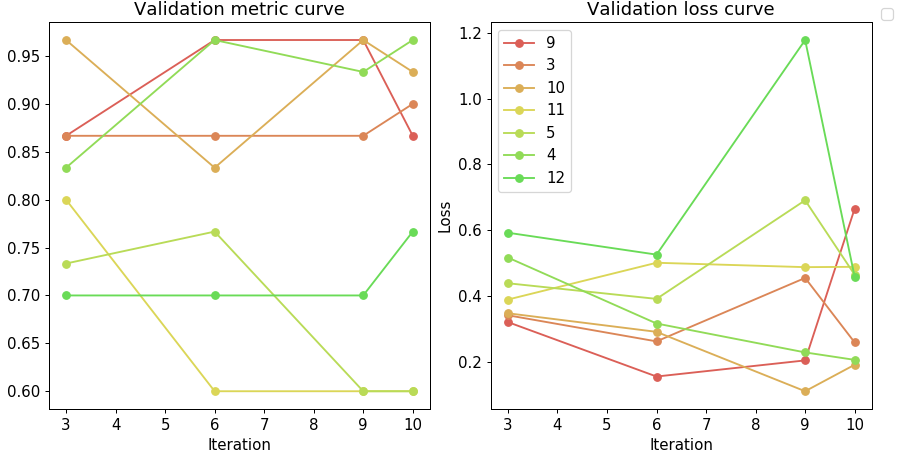

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [29]:
df_results = %sql SELECT * FROM iris_multi_model_info ORDER BY validation_loss ASC LIMIT 7;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM iris_multi_model_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
ax_metric.set_ylabel('Metric')
ax_metric.set_title('Validation metric curve')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Validation loss curve')

iters = df_summary['metrics_iters'][0]

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT validation_metrics,validation_loss FROM iris_multi_model_info WHERE mst_key = $mst_key
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    
    ax_metric.plot(iters, validation_metrics, label=mst_key, marker='o')
    ax_loss.plot(iters, validation_loss, label=mst_key, marker='o')

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

<a id="pred_prob"></a>
# 2.  Predict probabilities

Predict with probabilities for each class:

In [30]:
%%sql
DROP TABLE IF EXISTS iris_predict;

SELECT madlib.madlib_keras_predict('iris_multi_model', -- model
                                   'iris_test',        -- test_table
                                   'id',               -- id column
                                   'attributes',       -- independent var
                                   'iris_predict',     -- output table
                                    'prob',            -- prediction type
                                    FALSE,             -- use gpus
                                    3                  -- mst_key to use
                                   );

SELECT * FROM iris_predict ORDER BY id, rank;

Done.
1 rows affected.
90 rows affected.


[(3, u'class_text', u'Iris-setosa', 0.9999932, 1),
 (3, u'class_text', u'Iris-versicolor', 6.7611923e-06, 2),
 (3, u'class_text', u'Iris-virginica', 1.2535056e-10, 3),
 (10, u'class_text', u'Iris-setosa', 0.9999808, 1),
 (10, u'class_text', u'Iris-versicolor', 1.9209425e-05, 2),
 (10, u'class_text', u'Iris-virginica', 4.433645e-10, 3),
 (12, u'class_text', u'Iris-setosa', 0.99998367, 1),
 (12, u'class_text', u'Iris-versicolor', 1.6334934e-05, 2),
 (12, u'class_text', u'Iris-virginica', 4.3492965e-10, 3),
 (14, u'class_text', u'Iris-setosa', 0.9999931, 1),
 (14, u'class_text', u'Iris-versicolor', 6.9504345e-06, 2),
 (14, u'class_text', u'Iris-virginica', 1.9190094e-10, 3),
 (18, u'class_text', u'Iris-setosa', 0.99999726, 1),
 (18, u'class_text', u'Iris-versicolor', 2.719827e-06, 2),
 (18, u'class_text', u'Iris-virginica', 2.4018267e-11, 3),
 (20, u'class_text', u'Iris-setosa', 0.9999982, 1),
 (20, u'class_text', u'Iris-versicolor', 1.8036015e-06, 2),
 (20, u'class_text', u'Iris-virginica', 1.515534e-11, 3),
 (30, u'class_text', u'Iris-setosa', 0.99996376, 1),
 (30, u'class_text', u'Iris-versicolor', 3.623055e-05, 2),
 (30, u'class_text', u'Iris-virginica', 1.4014193e-09, 3),
 (31, u'class_text', u'Iris-setosa', 0.99995685, 1),
 (31, u'class_text', u'Iris-versicolor', 4.3105167e-05, 2),
 (31, u'class_text', u'Iris-virginica', 1.541236e-09, 3),
 (49, u'class_text', u'Iris-setosa', 0.99999833, 1),
 (49, u'class_text', u'Iris-versicolor', 1.6733742e-06, 2),
 (49, u'class_text', u'Iris-virginica', 1.0720992e-11, 3),
 (55, u'class_text', u'Iris-versicolor', 0.97456545, 1),
 (55, u'class_text', u'Iris-virginica', 0.025385397, 2),
 (55, u'class_text', u'Iris-setosa', 4.912654e-05, 3),
 (64, u'class_text', u'Iris-versicolor', 0.8837083, 1),
 (64, u'class_text', u'Iris-virginica', 0.11627731, 2),
 (64, u'class_text', u'Iris-setosa', 1.4444132e-05, 3),
 (70, u'class_text', u'Iris-versicolor', 0.9832433, 1),
 (70, u'class_text', u'Iris-virginica', 0.016161945, 2),
 (70, u'class_text', u'Iris-setosa', 0.0005947249, 3),
 (76, u'class_text', u'Iris-versicolor', 0.9934144, 1),
 (76, u'class_text', u'Iris-virginica', 0.006202936, 2),
 (76, u'class_text', u'Iris-setosa', 0.00038262276, 3),
 (82, u'class_text', u'Iris-versicolor', 0.9880006, 1),
 (82, u'class_text', u'Iris-virginica', 0.01050145, 2),
 (82, u'class_text', u'Iris-setosa', 0.0014980072, 3),
 (84, u'class_text', u'Iris-virginica', 0.743757, 1),
 (84, u'class_text', u'Iris-versicolor', 0.25624287, 2),
 (84, u'class_text', u'Iris-setosa', 1.1804799e-07, 3),
 (92, u'class_text', u'Iris-versicolor', 0.9489498, 1),
 (92, u'class_text', u'Iris-virginica', 0.050999135, 2),
 (92, u'class_text', u'Iris-setosa', 5.1051586e-05, 3),
 (98, u'class_text', u'Iris-versicolor', 0.9882598, 1),
 (98, u'class_text', u'Iris-virginica', 0.011410431, 2),
 (98, u'class_text', u'Iris-setosa', 0.00032975432, 3),
 (99, u'class_text', u'Iris-versicolor', 0.7122672, 1),
 (99, u'class_text', u'Iris-setosa', 0.2864844, 2),
 (99, u'class_text', u'Iris-virginica', 0.0012483773, 3),
 (102, u'class_text', u'Iris-virginica', 0.8344315, 1),
 (102, u'class_text', u'Iris-versicolor', 0.16556835, 2),
 (102, u'class_text', u'Iris-setosa', 4.9313943e-08, 3),
 (107, u'class_text', u'Iris-virginica', 0.7617606, 1),
 (107, u'class_text', u'Iris-versicolor', 0.23823881, 2),
 (107, u'class_text', u'Iris-setosa', 6.2156596e-07, 3),
 (114, u'class_text', u'Iris-virginica', 0.85601324, 1),
 (114, u'class_text', u'Iris-versicolor', 0.1439867, 2),
 (114, u'class_text', u'Iris-setosa', 3.4068247e-08, 3),
 (117, u'class_text', u'Iris-virginica', 0.76065344, 1),
 (117, u'class_text', u'Iris-versicolor', 0.23934652, 2),
 (117, u'class_text', u'Iris-setosa', 4.0775706e-08, 3),
 (121, u'class_text', u'Iris-virginica', 0.65924823, 1),
 (121, u'class_text', u'Iris-versicolor', 0.34075174, 2),
 (121, u'class_text', u'Iris-setosa', 3.7877243e-08, 3),
 (123, u'class_text', u'Iris-virginica', 0.968423, 1),
 (123, u'class_text', u'Iris-versicolor'

<a id="warm_start"></a>
# 3.  Warm start

Next, use the warm_start parameter to continue learning, using the coefficients from the run above. Note that we don't drop the model table or model summary table:

In [31]:
%%sql
SELECT madlib.madlib_keras_fit_multiple_model('iris_train_packed',    -- source_table
                                              'iris_multi_model',     -- model_output_table
                                              'mst_table',            -- model_selection_table
                                               3,                     -- num_iterations
                                               FALSE,                 -- use gpus
                                              'iris_test_packed',     -- validation dataset
                                               1,                     -- metrics compute frequency
                                               TRUE,                  -- warm start
                                              'Sophie L.',            -- name
                                              'Simple MLP for iris dataset'  -- description
                                             );

1 rows affected.


[('',)]

View summary:

In [32]:
%%sql
SELECT * FROM iris_multi_model_summary;

1 rows affected.


[(u'iris_train_packed', u'iris_test_packed', u'iris_multi_model', u'iris_multi_model_info', [u'class_text'], [u'attributes'], u'model_arch_library', u'mst_table', None, 3, 1, True, u'Sophie L.', u'Simple MLP for iris dataset', datetime.datetime(2021, 3, 6, 0, 55, 34, 10762), datetime.datetime(2021, 3, 6, 0, 56, 20, 576330), u'1.18.0-dev', [1], [u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica'], [u'character varying'], 1.0, [1, 2, 3])]

View performance of each model:

In [33]:
%%sql
SELECT * FROM iris_multi_model_info ORDER BY validation_metrics_final DESC;

12 rows affected.


[(9, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 1.18359375, [12.8246030807495, 28.3149819374084, 43.8511519432068], [u'accuracy'], u'categorical_crossentropy', 0.949999988079071, 0.125932246446609, [0.983333349227905, 0.908333361148834, 0.949999988079071], [0.0759517326951027, 0.280529856681824, 0.125932246446609], 0.966666638851166, 0.262804627418518, [0.966666638851166, 0.933333337306976, 0.966666638851166], [0.115140154957771, 0.282798647880554, 0.262804627418518]),
 (7, 2, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 1.18359375, [12.3267669677734, 27.5790538787842, 43.3719210624695], [u'accuracy'], u'categorical_crossentropy', 0.958333313465118, 0.646220803260803, [0.916666686534882, 0.774999976158142, 0.958333313465118], [0.760809063911438, 0.70676600933075, 0.646220803260803], 0.966666638851166, 0.676706075668335, [0.899999976158142, 0.699999988079071, 0.966666638851166], [0.789911270141602, 0.741125166416168, 0.676706075668335]),
 (6, 1, u"optimizer='Adam(lr=0.1)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [13.8655989170074, 29.3921880722046, 45.186311006546], [u'accuracy'], u'categorical_crossentropy', 0.966666638851166, 0.161019146442413, [0.608333349227905, 0.975000023841858, 0.966666638851166], [0.656926870346069, 0.154457986354828, 0.161019146442413], 0.966666638851166, 0.184286847710609, [0.666666686534882, 0.966666638851166, 0.966666638851166], [0.60343611240387, 0.166501134634018, 0.184286847710609]),
 (3, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [12.5584180355072, 27.7957689762115, 43.5938129425049], [u'accuracy'], u'categorical_crossentropy', 0.925000011920929, 0.125614732503891, [0.850000023841858, 0.908333361148834, 0.925000011920929], [0.311796188354492, 0.228279903531075, 0.125614732503891], 0.933333337306976, 0.205575048923492, [0.699999988079071, 0.899999976158142, 0.933333337306976], [0.434732705354691, 0.278642177581787, 0.205575048923492]),
 (1, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=4', u'madlib_keras', 0.75390625, [14.3016650676727, 29.8289239406586, 45.6773319244385], [u'accuracy'], u'categorical_crossentropy', 0.916666686534882, 0.680241525173187, [0.899999976158142, 0.899999976158142, 0.916666686534882], [0.75947380065918, 0.717410624027252, 0.680241525173187], 0.933333337306976, 0.685820519924164, [0.933333337306976, 0.933333337306976, 0.933333337306976], [0.764581918716431, 0.718774557113647, 0.685820519924164]),
 (2, 1, u"optimizer='Adam(lr=0.001)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [13.6457929611206, 29.1624140739441, 44.9534199237823], [u'accuracy'], u'categorical_crossentropy', 0.891666650772095, 0.590237081050873, [0.824999988079071, 0.783333361148834, 0.891666650772095], [0.666068911552429, 0.633061707019806, 0.590237081050873], 0.899999976158142, 0.576045572757721, [0.866666674613953, 0.866666674613953, 0.899999976158142], [0.645683944225311, 0.608498632907867, 0.576045572757721]),
 (4, 1, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy'", u'epochs=1,batch_size=8', u'madlib_keras', 0.75390625, [14.0837008953094, 29.6097829341888, 45.4142129421234], [u'accuracy'], u'categorical_crossentropy', 0.916666686534882, 0.174454689025879, [0.949999988079071, 0.958333313465118, 0.916666686534882], [0.166735425591469, 0.141851797699928, 0.174454689025879], 0.899999976158142, 0.219132959842682, [0.966666638851166, 0.933333337306976, 0.899999976158142], [0.186790466308594, 0.176578417420387, 0.219132959842682]),
 (10, 2, u"optimizer='Adam(lr=0.01)',metrics=['accuracy'],loss='categorical_crossentropy

Plot validation results:

7 rows affected.
1 rows affected.


<IPython.core.display.Javascript object>


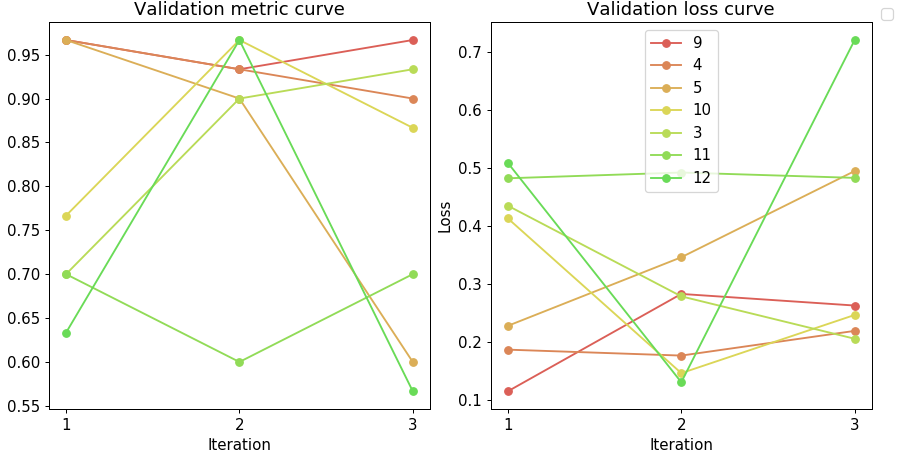

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [34]:
df_results = %sql SELECT * FROM iris_multi_model_info ORDER BY validation_loss ASC LIMIT 7;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM iris_multi_model_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
ax_metric.set_ylabel('Metric')
ax_metric.set_title('Validation metric curve')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Validation loss curve')

iters = df_summary['metrics_iters'][0]

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT validation_metrics,validation_loss FROM iris_multi_model_info WHERE mst_key = $mst_key
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    
    ax_metric.plot(iters, validation_metrics, label=mst_key, marker='o')
    ax_loss.plot(iters, validation_loss, label=mst_key, marker='o')

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)